In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [6]:
from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
import pandas as pd
%config Completer.use_jedi = False

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1770: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 144 results
transitions_data returned 335 results
total_population_data returned 108 results
initialization time:  6.990511894226074
simulation_time:  7.3016581535339355
initialization time:  6.682854175567627
simulation_time:  7.4303038120269775
initialization time:  6.655448913574219
simulation_time:  7.215181112289429


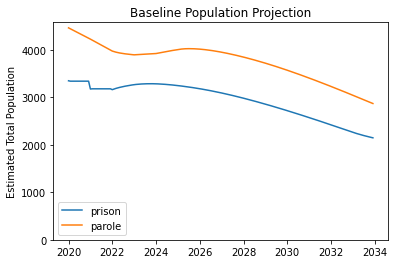

In [12]:
path_from_state_folder = 'SC/SC_prison_model_inputs.yaml'
display_compartments = ['prison', 'parole']
test_sim = SuperSimulationFactory.build_super_simulation('../state/' + path_from_state_folder)
test_sim.simulate_baseline(display_compartments)